# Scripts for the controller design

## Imports and contants of the system

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal

p = 64.986
K = 2652.28 

## Utility function for obtaining transfer function from designing constants

In [3]:
def get_transfer_function(damping_ratio, beta1, beta2):
    wn = p/(beta2 * damping_ratio)
    Q = (beta1 ** 2) - 2 * beta1 + (1/(damping_ratio ** 2))
    r1 = (damping_ratio * wn * (beta1 * ((1/(damping_ratio**2)) - 4) + (2/(damping_ratio**2))))/Q
    r2 = ((wn**2) * ((1/(damping_ratio**2)) - (2*beta1)))/Q
    r3 = ((beta1**3) * damping_ratio * wn)/Q
    num = np.polyadd(
        np.polymul([r1, r2], [1, beta1*damping_ratio*wn]), 
        np.polymul([r3], [1, 2*damping_ratio*wn, (wn**2)])
    )
    den = np.polymul(
        [1, 2*damping_ratio*wn, (wn**2)], 
        [1, beta1*damping_ratio*wn]
    )
    return signal.lti(num, den)

## Overshoot design (Mp is independent of Beta2)

Valid pairs: [(0.3, 16.72677097097097), (0.3, 16.7568009009009), (0.3, 16.78683083083083), (0.3, 16.81686076076076), (0.3, 16.84689069069069), (0.3, 16.87692062062062), (0.3, 16.90695055055055), (0.3, 16.93698048048048), (0.3, 16.96701041041041), (0.3, 16.99704034034034), (0.3, 17.02707027027027), (0.3, 17.0571002002002), (0.3, 17.08713013013013), (0.3, 17.11716006006006), (0.3, 17.14718998998999), (0.3, 17.177219919919917), (0.3, 17.20724984984985), (0.3, 17.23727977977978), (0.3, 17.267309709709707), (0.3, 17.297339639639638), (0.3, 17.32736956956957), (0.3, 17.357399499499497), (0.3, 17.387429429429428), (0.3, 17.41745935935936), (0.3, 17.447489289289287), (0.3, 17.477519219219218), (0.3, 17.50754914914915), (0.3, 17.537579079079077), (0.3, 17.567609009009008), (0.3, 17.59763893893894), (0.3, 17.627668868868867), (0.3, 17.657698798798798), (0.3, 17.68772872872873), (0.3, 17.717758658658656), (0.3, 17.747788588588588), (0.3, 17.77781851851852), (0.3, 17.807848448448446), (0.3, 17.837

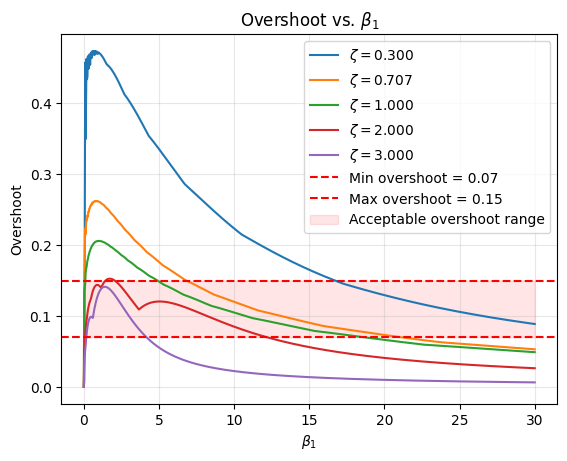

In [25]:
min_overshoot = 0.07
max_overshoot = 0.15
beta_2 = 1.0
beta_1_list = np.linspace(0.0001, 30.0, 1000)
damping_ratios = [0.3, 0.707, 1.0, 2.0, 3.0]

overshoots = {}
valid_pairs = []
for damping_ratio in damping_ratios:
    overshoots[f"$\\zeta = {damping_ratio:.3f}$"] = []
    for beta_1 in beta_1_list:
        tf = get_transfer_function(damping_ratio, beta_1, beta_2)
        t, y = signal.step(tf)
        overshoot = (np.max(y) - 1) / 1
        overshoots[f"$\\zeta = {damping_ratio:.3f}$"].append(overshoot)
        if min_overshoot <= overshoot <= max_overshoot:
            valid_pairs.append((damping_ratio, beta_1))


for key, value in overshoots.items():
    plt.plot(beta_1_list, value, label=key)

plt.axhline(min_overshoot, color='r', linestyle='--', label=f"Min overshoot = {min_overshoot}")
plt.axhline(max_overshoot, color='r', linestyle='--', label=f"Max overshoot = {max_overshoot}")
plt.fill_between(beta_1_list, min_overshoot, max_overshoot, color='r', alpha=0.1, label="Acceptable overshoot range")
plt.title("Overshoot vs. $\\beta_1$")
plt.xlabel("$\\beta_1$")
plt.ylabel("Overshoot")
plt.legend()
plt.grid(alpha=0.3)
print(f"Valid pairs: {valid_pairs}")

## Stablish time design 


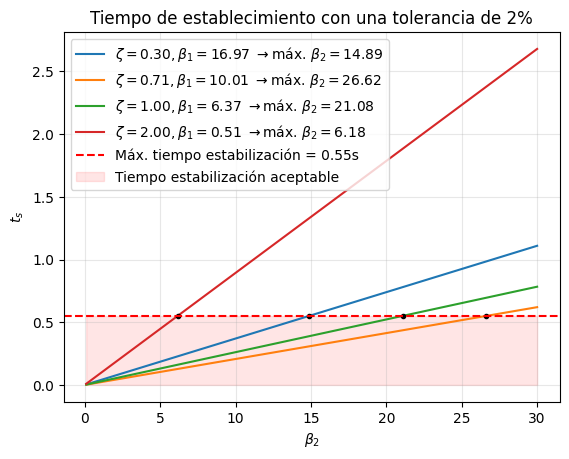

In [48]:
def get_stablish_time(t, y, tolerance=0.02):
    i_ts = 0
    for i in range(len(y)):
        if y[i] >= 1 + tolerance or y[i] <= 1 - tolerance:
            i_ts = i
    return t[i_ts + 1]

max_rising_time = 0.55
valid_pairs = [(0.3, 16.974040404040405), (0.707, 10.006666666666666), (1.0, 6.371515151515151), (2.0, 0.51060880)]
beta_2_list = np.linspace(0.1, 30, 1000)

rising_times = {}
for damping_ratio, beta_1 in valid_pairs:
    rising_times[f"$\\zeta = {damping_ratio:.2f}, \\beta_1 = {beta_1:.2f}$"] = []
    beta_2_max = 0
    for beta_2 in beta_2_list:
        tf = get_transfer_function(damping_ratio, beta_1, beta_2)
        t, y = signal.step(tf)
        ts = get_stablish_time(t, y)
        rising_times[f"$\\zeta = {damping_ratio:.2f}, \\beta_1 = {beta_1:.2f}$"].append(ts)
        if (ts > max_rising_time and beta_2_max == 0):
            beta_2_max = beta_2

    plt.plot(beta_2_list, rising_times[f"$\\zeta = {damping_ratio:.2f}, \\beta_1 = {beta_1:.2f}$"], label=f"$\\zeta = {damping_ratio:.2f}, \\beta_1 = {beta_1:.2f}$ " + r'$\rightarrow$' + f"máx. $\\beta_2 = {beta_2_max:.2f}$")
    plt.plot(beta_2_max, max_rising_time, '.', color='k')

plt.axhline(max_rising_time, color='r', linestyle='--', label=f"Máx. tiempo estabilización = {max_rising_time}s")
plt.fill_between(beta_2_list, max_rising_time, 0, color='r', alpha=0.1, label="Tiempo estabilización aceptable")
plt.xlabel("$\\beta_2$")
plt.ylabel("$t_s$")
plt.title("Tiempo de establecimiento con una tolerancia de 2%")
plt.grid(alpha=0.3)
plt.legend()

## Rising time design 



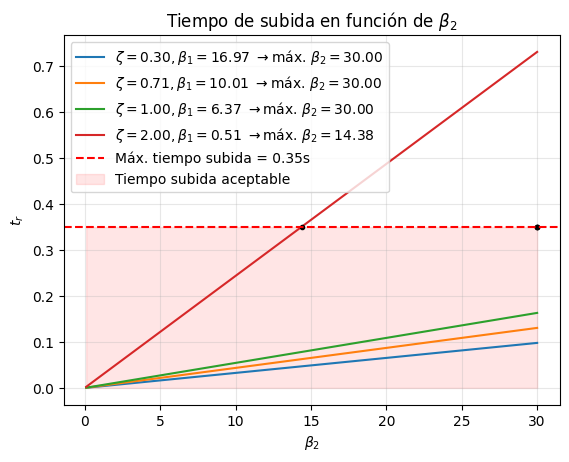

In [51]:
def get_rising_time(t, y):
    i_ts = 0
    for i in range(len(y)):
        if y[i] >= 1:
            return t[i+1]

max_rising_time = 0.35
valid_pairs = [(0.3, 16.974040404040405), (0.707, 10.006666666666666), (1.0, 6.371515151515151), (2.0, 0.51060880)]
beta_2_list = np.linspace(0.1, 30, 1000)

rising_times = {}
for damping_ratio, beta_1 in valid_pairs:
    rising_times[f"$\\zeta = {damping_ratio:.2f}, \\beta_1 = {beta_1:.2f}$"] = []
    beta_2_max = 0
    for beta_2 in beta_2_list:
        tf = get_transfer_function(damping_ratio, beta_1, beta_2)
        t, y = signal.step(tf)
        ts = get_rising_time(t, y)
        rising_times[f"$\\zeta = {damping_ratio:.2f}, \\beta_1 = {beta_1:.2f}$"].append(ts)
        if (ts > max_rising_time and beta_2_max == 0):
            beta_2_max = beta_2

    if beta_2_max == 0:
        beta_2_max = beta_2_list[-1]
    plt.plot(beta_2_list, rising_times[f"$\\zeta = {damping_ratio:.2f}, \\beta_1 = {beta_1:.2f}$"], label=f"$\\zeta = {damping_ratio:.2f}, \\beta_1 = {beta_1:.2f}$ " + r'$\rightarrow$' + f"máx. $\\beta_2 = {beta_2_max:.2f}$")
    plt.plot(beta_2_max, max_rising_time, '.', color='k')

plt.axhline(max_rising_time, color='r', linestyle='--', label=f"Máx. tiempo subida = {max_rising_time}s")
plt.fill_between(beta_2_list, max_rising_time, 0, color='r', alpha=0.1, label="Tiempo subida aceptable")
plt.xlabel("$\\beta_2$")
plt.ylabel("$t_r$")
plt.title("Tiempo de subida en función de $\\beta_2$")
plt.grid(alpha=0.3)
plt.legend()

## Step response of the system (Used for visualization)


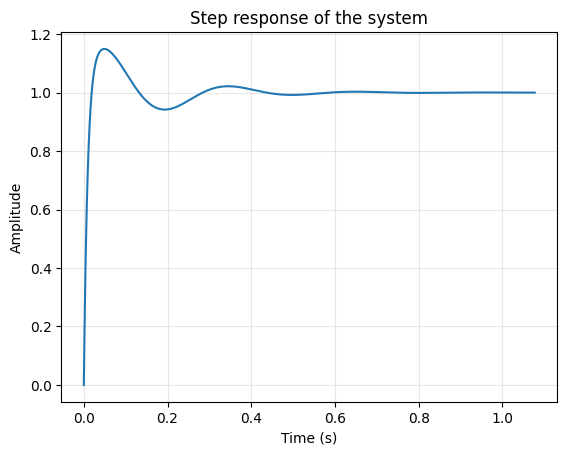

In [28]:
beta_2 = 10
beta_1 = 17
damping_ratio = 0.3
tf = get_transfer_function(damping_ratio, beta_1, beta_2)
t, y = signal.step(tf, N=100000)
plt.figure()
plt.plot(t, y)
plt.title("Step response of the system")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.grid(alpha=0.3)
plt.show()